In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import interp1d
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('data/transparency.csv')

In [3]:
def ice_transparency(df, datum=1950):
    df["z"] = df["depth"] - datum
    
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    f_scattering = interp1d(df["z"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z"], df["absorption_len_norm"])
    return f_scattering, f_absorption, df

In [4]:
f_scattering, f_absorption, df_processed = ice_transparency(df)

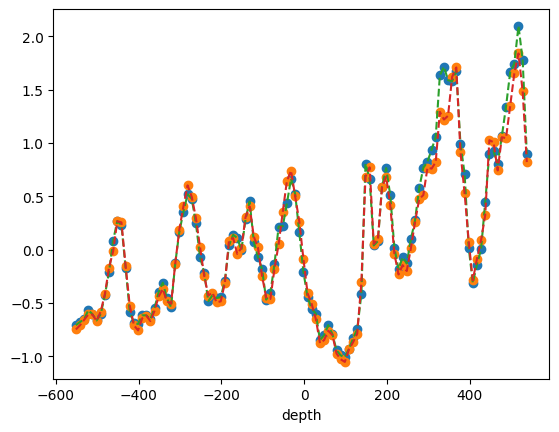

In [5]:
plt.plot(df['z'], df['scattering_len_norm'], 'o')
plt.plot(df['z'], df['absorption_len_norm'], 'o')
plt.plot(df['z'], f_scattering(df["z"]), '--')
plt.plot(df['z'], f_absorption(df["z"]), '--')
plt.xlabel('depth')

plt.show()

In [37]:
sensor_df = pd.read_csv('data/sensor_geometry.csv')

In [38]:
sensor_df['scattering'] = f_scattering(sensor_df['z'])
sensor_df['absorption'] = f_absorption(sensor_df['z'])

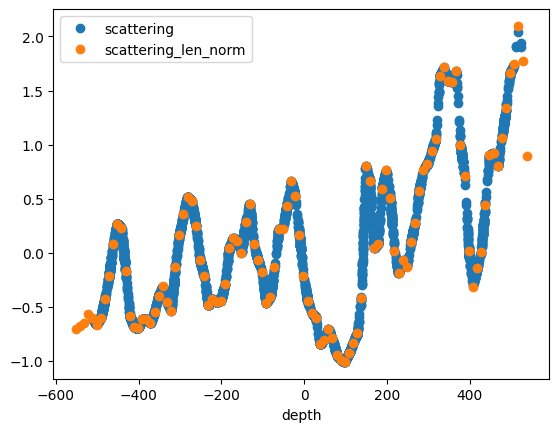

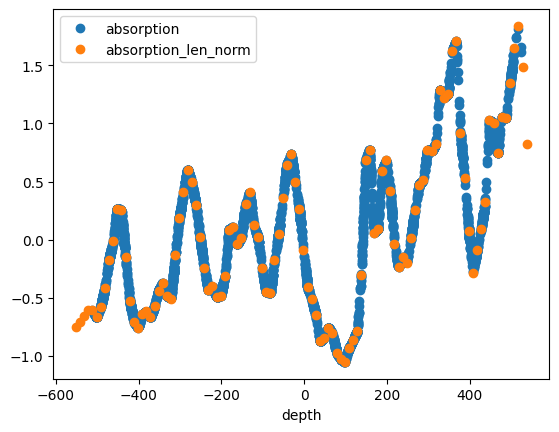

In [39]:
plt.plot(sensor_df['z'], sensor_df['scattering'], 'o', label='scattering')
plt.plot(df['z'], df['scattering_len_norm'], 'o', label='scattering_len_norm')
plt.xlabel('depth')
plt.legend()
plt.show()

plt.plot(sensor_df['z'], sensor_df['absorption'], 'o', label='absorption')
plt.plot(df['z'], df['absorption_len_norm'], 'o', label='absorption_len_norm')
plt.xlabel('depth')
plt.legend()
plt.show()

In [40]:
sensor_df["string"] = 0

for i in range(len(sensor_df) // 60):
    start, end = i * 60, (i * 60) + 60
    sensor_df.loc[start:end, "string"] = i

In [41]:
list_core = [25,26,35,36,45,44,34,80,81,85,83,84,78,79,82]
list_core = sorted(list_core)
list_core

[25, 26, 34, 35, 36, 44, 45, 78, 79, 80, 81, 82, 83, 84, 85]

In [42]:
sensor_df['type'] = 4
sensor_df.loc[(sensor_df['z'] >= -156.41 + 7 + 40), 'type'] = 1
sensor_df.loc[(sensor_df['z'] > -156.41 + 7) & (sensor_df['z'] < -156.41 + 7 + 40), 'type'] = 2
sensor_df.loc[(sensor_df['string'].isin(list_core)) & (sensor_df['z'] < -156.41 + 7), 'type'] = 3

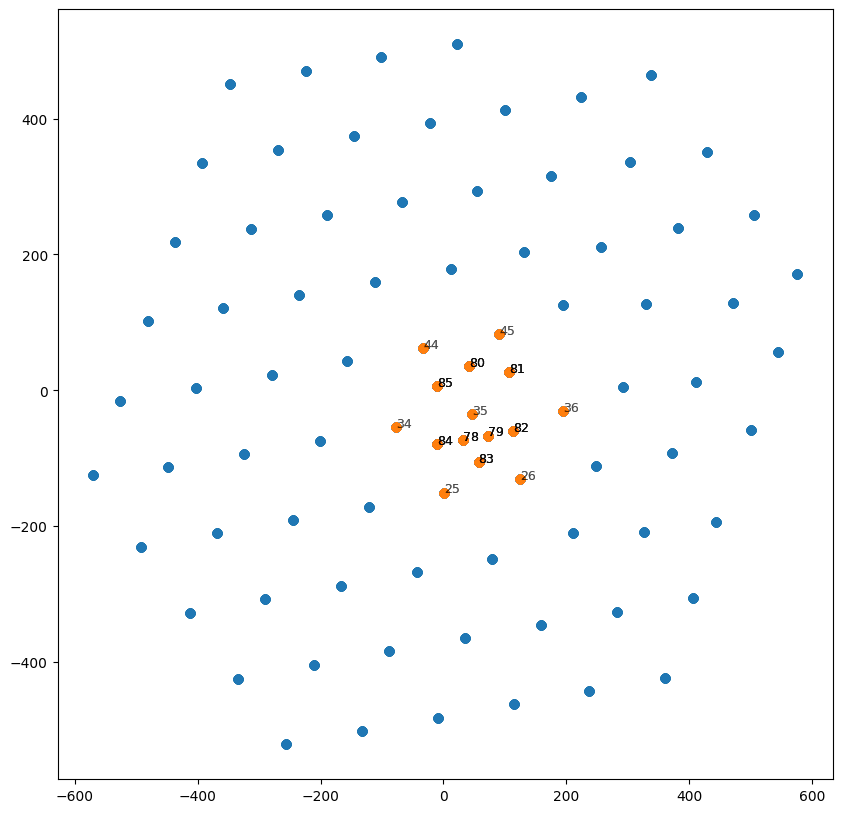

In [43]:
# size of the plot
plt.figure(figsize=(10, 10))
plt.scatter(sensor_df['x'], sensor_df['y'])
plt.scatter(sensor_df.loc[sensor_df['type'] == 3, 'x'], sensor_df.loc[sensor_df['type'] == 3, 'y'])
# print string number on top of each core
for i in range(len(sensor_df)):
    if sensor_df.loc[i, 'type'] == 3:
        plt.text(sensor_df.loc[i, 'x'], sensor_df.loc[i, 'y'], sensor_df.loc[i, 'string'], fontsize=9, alpha=0.05)
plt.show()


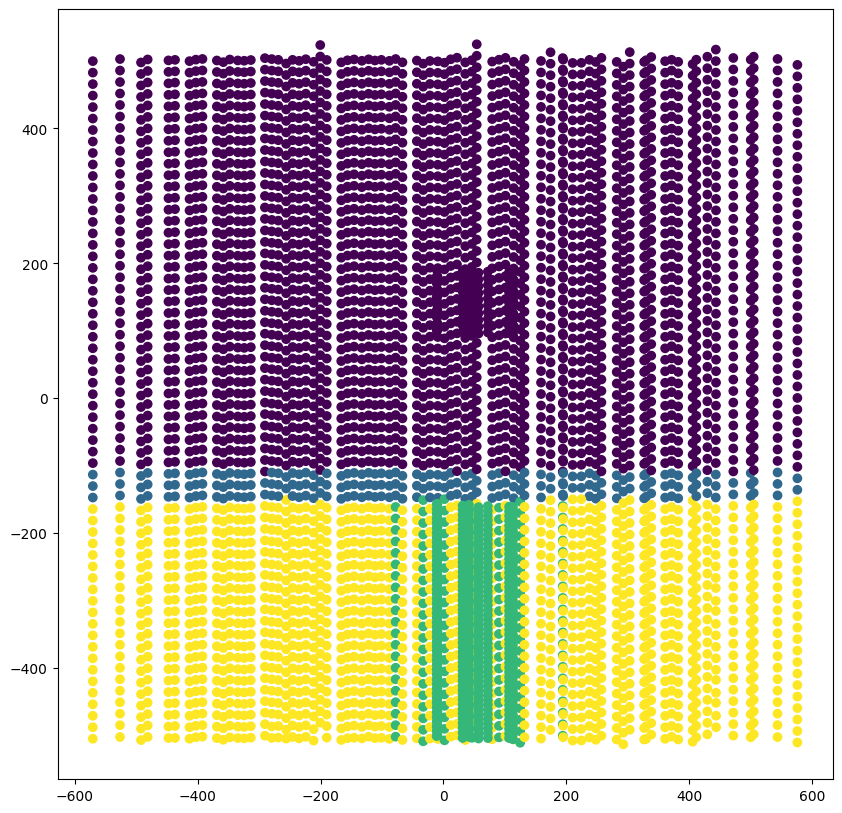

In [44]:
# plot x and z and color code type
plt.figure(figsize=(10, 10))
plt.scatter(sensor_df['x'], sensor_df['z'], c=sensor_df['type'])

plt.show()


In [45]:
sensor_df.drop(columns=['string'], inplace=True)

In [46]:
# one hot encoding of type using sklearn OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(sensor_df[['type']]).toarray())
sensor_df = sensor_df.join(enc_df)
sensor_df.rename(columns={0: 'f0', 1: 'f1', 2: 'f2', 3: 'f3'}, inplace=True)
sensor_df.drop(columns=['type'], inplace=True)
# convert f0, f1, f2, f3 to int
sensor_df['f0'] = sensor_df['f0'].astype(int)
sensor_df['f1'] = sensor_df['f1'].astype(int)
sensor_df['f2'] = sensor_df['f2'].astype(int)
sensor_df['f3'] = sensor_df['f3'].astype(int)

In [48]:
sensor_df.to_csv('data/sensor_geometry_fe.csv', index=False)